<h1 style="color: navy bleu;text-align:center">  M2 MAS DS- Problèmes inverses et optimisation convexe

<h2 style="color: navy bleu;text-align:center"> Rendu du TP3 : Reconstruction en tomographie par émission (TEP)

<h3 style="color: navy bleu"> Saïda Guezoui, groupe DS </h3>

        <h2 style="color: navy bleu"> I. Introduction 

Dans ce TP, nous allons travailler avec l'image du phantôme de Shepp-Logan qui simule un cerveau.

<img src="y128.png" alt="Shepp-Logan" width="128" height="128"/>


Nous allons commencer par découvrir la transformée de Radon, générer des observations non bruitées et bruitées. Ensuite, on fera une reconstruction par l'opérateur inverse (rétroprojection / rétroprojection filtrée) pour enfin finir avec une reconstruction à l'aide du seuillage itératif. 

Ci-dessous, nous importons les bibliothèques nécessaires pour ce tp.

In [1]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import radon
from skimage.transform import iradon
import pywt

<h2 style="color: navy bleu"> II. Gestion des images

<h3 style="color: navy bleu">  A.  Chargement de l'image

In [2]:
#on charge l'image de lena à l'aide de la fonction imread de la bibliothèque image de matplotlib
y =mpimg.imread("y128.png")

#l'image est de type int ou float on la cast en float pour pouvoir faire des calculs
# et on la remet à l'échelle si besoin
if (y.dtype=='float32') :
    y=y*255
y=y.astype(float)
#la taille de l'image peut s'obtenir à l'aide de l'attribut shape
[n1,n2]=y.shape

# on affiche le maximum et le minimum pour vérifier que les valeurs de niveau de gris varient 
# bien entre 0 et 255 (et pas 0 et 1 par exemple)

print([y.min(), y.max()])

[0.0, 255.0]


Les valeurs de niveaux de gris varient bien entre 0 et 255 (valeurs min et max affichées ci-dessus)

<h3 style="color: navy bleu">B. Affichage de l'image

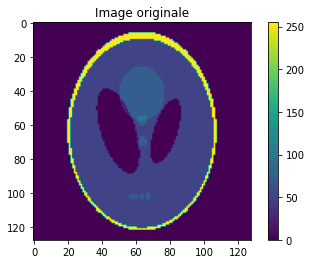

In [3]:
#on affiche l'image à l'aide de la fonction imshow de la bibliothèque pyplot de matplotlib
#on donne un numero à la figure
plt.figure(1)
#on l'affiche en niveau de gris
plt.imshow(y)
#on affiche la colorbar associée
plt.colorbar()
#on lui donne un titre
plt.title('Image originale')
#on affiche tout cela sur la figure 1
plt.show()

<h3 style="color: navy bleu"> C. Fonctions utiles du TP2

In [4]:
def snr(x,xref):
    s = 10*np.log10(np.mean(xref**2)/np.mean((xref-x)**2))
    return s

def psnr(x,xref):
    s = 10*np.log10(255**2/np.mean((xref-x)**2))
    return s

<h2 style="color: navy bleu"> III. Acquisition en tomographie TEP

Le modèle d'observation dans le cas de la tomographie TEP est une observation bruitée de type Poisson de la transformée de Radon :
$$
z=\mathcal{P}_\alpha( \mathcal R (y))
$$
où
<ul>
<li> $z$ : sinogramme (observations)</li>
<li> $y$ : données originales</li>
<li> $\mathcal R$ : la transformée de Radon</li>
<li> $\mathcal{P}_\alpha$ : bruit Poissonien de paramètre d'échelle $\alpha >0$. (On rappelle $\mathcal{P}_\alpha(a) =\mathcal{P}_1(\alpha a)$).</li>
</ul>

<table>
<tr>
<td>
<img src="y.png" alt="objet" />
</td>
<td>
<img src="Ry.png" alt="objet" />
</td>
<td>
<img src="z.png" alt="objet" />
</td>
</tr>
<tr>
<td style="text-align:center">
Objet $y$
</td>
<td style="text-align:center">
Observation parfaite $\mathcal R y$
</td>
<td style="text-align:center">
Observation bruitée $z$ pour $\alpha = 0.1$
</td>
</tr>
</table>

### Implémentation de la transformée de Radon

On rappelle 
 
#### Transformée de Radon en continu:
$f\in L^2(\mathbb R^2)$, $\forall (u,\theta)\in \mathbb R \times [0,\pi)$ :
\begin{align*}
\mathcal R_f(u,\theta) &= p_\theta(u)= \int_{\mathbb R} \int_{\mathbb R} f(x,y)\delta(x\cos  \theta +y\sin \theta -u)dxdy  
\end{align*}

Ici nous discrétisons la transformée de Radon en considérant pour une image $y$ de taille $N_1\times N_2$:
<ul>
<li> $\theta\in\{0,\Delta, 2\Delta,\dots,(K-1)\Delta\}=\{\theta_0,\theta_1,\dots,\theta_K\}$ où $\Delta = \left \lfloor{180/K}\right\rfloor$, $\theta$ est exprimé en degré.</li>
<li> $u\in\mathbb Z$.</li>
</ul>

Nous avons
#### Transformée de Radon en discret:
\begin{align*}
\mathcal R_y(u,\theta)=\sum_{k=1}^K \sum_{i=1}^{N_1} \sum_{j=1}^{N_2}y(i,j)\delta\Bigl( \left \lfloor(i-N_1/2)\cos( \pi\theta_k/180) +(j-N_2/2)\sin( \pi\theta_k/180) \right\rfloor=u\Bigr)  
\end{align*}
où $\delta$ représente la fonction delta de Dirac.

On note que  $\mathcal R_y(u,\theta)$ est nul pour $u$ tel que $|u|\geq\sqrt{ (N_1^2+N_2^2) /2}$. Numériquement, on ne calculera donc $\mathcal R_y(u,\theta)$ que pour $u$ vérifiant $|u|\leq\sqrt{ (N_1^2+N_2^2) /2}$. Notons $\text{npixels}$ le nombre de telles valeurs entières de $u$. L'opérateur de Radon discret $\mathcal R$ :
$$\mathcal R : \mathbb R^{N_1\times N_2} \to \mathbb R^{\text{npixels}\times K} $$
envoie donc une image de taille $N_1\times N_2$ sur des mesures de tailles $\text{npixels}\times K$ où $\text{npixels}$ correspond au nombre de pixels du détecteur et $K$ au nombre d'angles de vue acquis.

Cet opérateur est codé en Python par la fonction <em>radon</em> disponible dans le module  <em>scikit-image</em> (http://scikit-image.org/) qui prend en argument l'image à traiter ($y$) et de manière optionnelle la liste des angles discrets $\{\theta_0,\theta_1,\dots,\theta_K\}$ et retourne le sinogramme ($\mathcal R (y)$) de taille : $\text{npixels} \times K$.

<h3 style="color: navy bleu"> A. Construction des observations non bruitées

<h4 style="color: navy bleu"> A.1. Création de la fonction  <em>genereTEP</em> : </h4>

Elle prend en entrée une image $y$, le nombre d'angle $K$ et génère les observations non bruitées $z= \mathcal R (y)$.

In [5]:
#1
def genereTEP(y,K): 
    """
    y : image
    K : le nombre d'angle 
    
    """
    theta = np.linspace(0., 180,K, endpoint=False)
    
    return radon(y, theta)

<h4 style="color: navy bleu"> A.2. Affichage de l'image originale et l'observation pour $K=180$ et pour $K=90$

Text(0.5, 1.0, 'image non bruitée avec K=90')

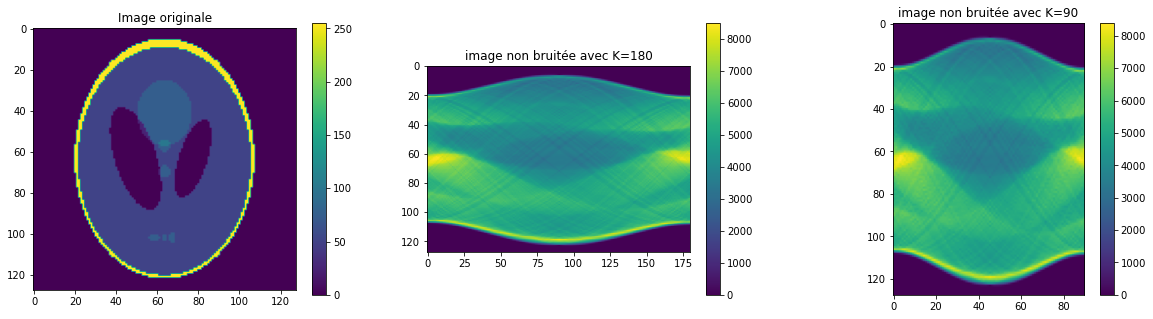

In [6]:
#2. 
# Affichage de l'image originale 
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.imshow(y)
plt.colorbar()
plt.title('Image originale')

# Affichage de l'image non bruitée avec K = 180 
plt.subplot(1, 3, 2)
plt.imshow(genereTEP(y, 180))
plt.colorbar()
plt.title('image non bruitée avec K=180')

# Affichage de l'image non bruitée avec K = 90 
plt.subplot(1, 3, 3)
plt.imshow(genereTEP(y, 90))
plt.colorbar()
plt.title('image non bruitée avec K=90')

<h2 style="color: navy bleu"> IV. Construction des observations bruitées

<h3 style="color: navy bleu"> A. Création de la fonction <em>genereTEPbruitee </em> </h3> 

Elle prend en entrée une image $y$, le nombre d'angles $K$, le paramètre d'échelle $\alpha$ et génère l'observation bruitée $z=\mathcal{P}_\alpha(\mathcal R (y))$.

In [7]:
def genereTEPbruitee(y,K,alpha): 
    """
    y : image
    K : nombre d'angle 
    alpha : paramètre d'échelle
    """
    theta = np.linspace(0., 180,K, endpoint=False)
    obs_bruite = radon(y, theta)
    
    return np.random.poisson(alpha*obs_bruite) 

<h3 style="color: navy bleu"> B. Affichage des observations obtenues avec les différentes variations de $\alpha$ 

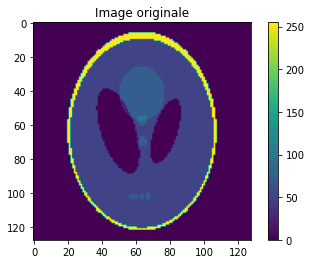

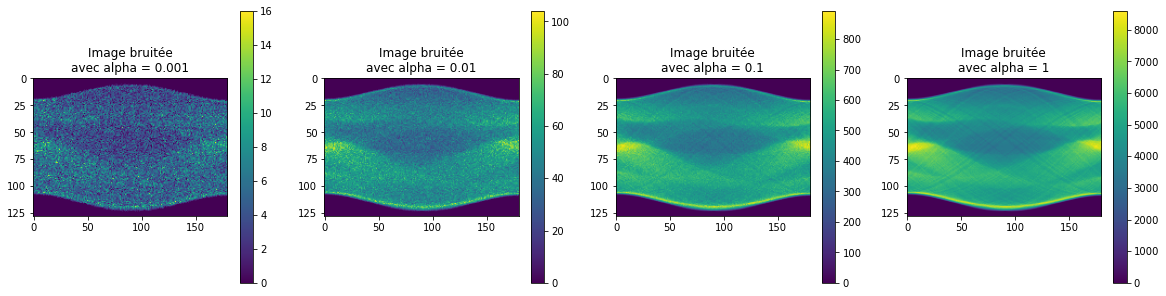

In [8]:
#2. 
alpha_list = [0.001, 0.01, 0.1, 1]

# Affichage de l'image originale 
plt.imshow(y)
plt.colorbar()
plt.title('Image originale')

plt.figure(figsize=(20,5))
for i in range(len(alpha_list)):
    plt.subplot(1, len(alpha_list), i+1)
    plt.imshow(genereTEPbruitee(y, 180, alpha_list[i]))
    plt.colorbar()
    plt.title(f'Image bruitée\navec alpha = {alpha_list[i]}')


- Remarque : 

D'après les résultats obtenus, plus $\alpha$ est grand, plus la valeur maximale d'observation z est élevée. En effet, pour $\alpha = 1$, la valeur maximale est de 8000 contrairement aux autres images où ça diminue jusqu'à 16 pour $\alpha$ = 0.001. On remarque également que la valeur minimale est égale à 0 pour toutes les observations z. 

Comme on a une dynamique différente, on ne peut pas directement faire une comparaison. On doit donc faire une normalisation avec cette relation entre l'observation bruitée et non bruitée : snr(obs_bruite/alpha, obs_non_bruite), autrement dit : 
$$SNR(\frac{z}{\alpha}, R(y))$$

On remarque également que lorsque $\alpha = 1$, nous avons la même échelle (valeur maximale et minimale des observations) comparé à un sinogramme non bruité. 


<h3 style="color: navy bleu"> C. Calcul du SNR obtenu pour toutes les valeurs de $\alpha$ 

In [9]:
# 3.b. 
for i in alpha_list:
    obs_bruite = genereTEPbruitee(y, 180, i)
    obs_non_bruite = genereTEP(y, 180)
    SNR = snr((1/i)*obs_bruite, obs_non_bruite)
    
    print("Résultat = ",(i, SNR))

Résultat =  (0.001, 7.142870152095613)
Résultat =  (0.01, 17.10861488147142)
Résultat =  (0.1, 27.111937107014544)
Résultat =  (1, 37.05200036772367)


- Remarque : 

On constate que plus $\alpha$ est grand, plus on a un SNR important, on a donc une meilleure restauration avec $\alpha = 1$.  

### Dans la suite du TP, on fixe $\alpha=0.1$ 

<h2 style="color: navy bleu"> V. Reconstruction par l'opérateur inverse : la rétroprojection filtrée

On rappelle la rétroprojection (qui est l'opérateur adjoint de la transformée de Radon) et la rétroprojection filtrée (qui est son inverse) en continu:
### Rétroprojection en continu :
$p\in L^2([0,\pi)\times \mathbb R)$, $\forall (x,y)\in\mathbb R^2$ :
\begin{align*}
\mathcal B_p(x,y) 
&= \int_0^\pi \int_\mathbb R p(\theta,u)\delta(x\cos \theta +y\sin \theta -u)dud\theta  
\end{align*}


### Rétroprojection filtrée en continu :
 $\forall\ (x,y)\in\mathbb R^2$ :
  \begin{align*}
 f(x,y)& =\tfrac{1}{2\pi}\int_0^\pi 
 (\mathcal R_f(.,\theta)\star h) (x\cos\theta+y\sin\theta) d\theta\\
 &=\tfrac{1}{2\pi}\int_0^\pi
\mathcal{F}^{-1}_{1D}\bigl[ |\xi| \mathcal{F}_{1D} (R_f(.,\theta)) (\xi)\bigr](x\cos\theta+y\sin\theta)  d\theta
\end{align*}
où $\mathcal{F}_{1D}$ est la transformée de Fourier en 1D et $h:\mathbb R\to\mathbb R$ telle que $\mathcal{F}_{1D} (h) (\xi) = |\xi|$
est appelé  filtre rampe.



La fonction <em>iradon</em> du module  <em>scikit-image</em> (http://scikit-image.org/)  permet de calculer la rétroprojection et la rétroprojection filtrée.
Pour la rétroprojection filtrée,  <em>iradon</em> permet de choisir le filtre $h$, on utilisera ici le filtre 'ramp'. Pour la rétroprojection, elle peut se calculer comme la rétroprojection filtrée en remplaçant le filtre $h$ par un delta de Dirac (autrement dit on ne filtre pas). <em>iradon</em> code donc la rétroprojection en spécifiant le filtre 'None' (voir la doc).


<h3 style="color: navy bleu"> A. Rétroprojection

<h4 style="color: navy bleu"> A.1. Création de la fonction <em>retroprojection</em> </h4>

Elle prend en entrée un sinogramme $z$, le nombre d'angle $K$ et calcule la rétroprojection de $z$.

In [10]:
#1. 
def retroprojection(z,K): 
    """
    z : image 
    K : nombre d'angles
    """
    theta = np.linspace(0., 180,K, endpoint=False)
    return iradon(z, theta=theta,filter_name=None)

<h4 style="color: navy bleu"> A.2. Application de la  <em>retroprojection</em> au sinogramme non bruité pour $K=90$ et $K=180$ 

Text(0.5, 1.0, 'Image originale')

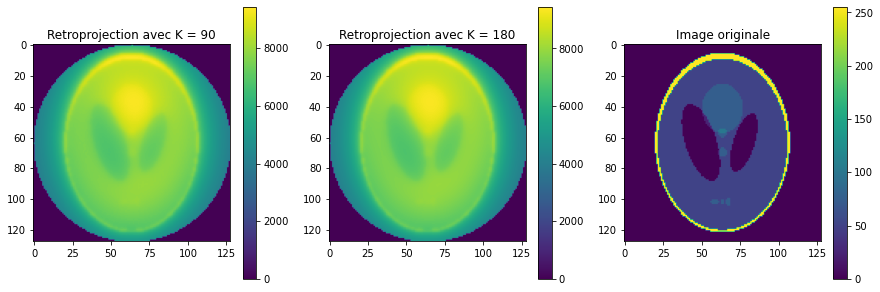

In [11]:
#2. 
z = genereTEP(y, 90)
plt.figure(figsize=(15,5))
#Retroprojection avec K = 90
plt.subplot(1, 3, 1)
plt.imshow(retroprojection(z, 90))
plt.colorbar()
plt.title('Retroprojection avec K = 90')

z1 = genereTEP(y, 180)

# Retroprojection avec K = 180
plt.subplot(1, 3, 2)
plt.imshow(retroprojection(z1, 180))
plt.colorbar()
plt.title('Retroprojection avec K = 180')

# Image originale 
plt.subplot(1, 3, 3)
plt.imshow(y)
plt.colorbar()
plt.title('Image originale')

- Remarque :

L'image obtenue a un lien avec $y$ néanmoins ce n'est pas une bonne approximation de $y$ car le centre de l'image n'a pas été bien reconstruit surtout avec un angle de 90. 

<h3 style="color: navy bleu"> B. Inversion par rétroprojection filtrée

<ol> 
<li> En examinant la doc de <em>iradon</em>, créez une fonction <em>retroprojectionFiltree</em> qui prend en entrée un sinogramme $z$ et le nombre d'angle $K$ et calcule la rétroprojection filtrée de $z$.</li>
<li> Appliquez  <em>retroprojectionFiltree</em> au sinogramme non bruité pour $K=180$ et visualisez le résultat ainsi que la différence avec l'image exacte. A-t-on reconstruction exacte ? (Quantifiez en utilisant le SNR).</li>
<li> Appliquez  <em>retroprojectionFiltree</em> au sinogramme non bruité pour $K=45$ et visualisez le résultat ainsi que la différence avec l'image exacte, calculez le SNR. Quel est l'effet de réduire le nombre d'angles ?</li>
<li> Appliquez <em>retroprojectionFiltree</em> au sinogramme bruité pour $K=180$  et visualisez. Quantifiez la qualité du résultat en utilisant le SNR.
</ol>

<h4 style="color: navy bleu"> B.1. Création de la fonction <em>retroprojectionFiltree</em> </h4>

Elle prend en entrée un sinogramme $z$, le nombre d'angle $K$ et calcule la rétroprojection filtrée de $z$.

In [12]:
def retroprojectionFiltree(z, K):
    """
    z : image
    K : nombre d'angles 
    """
    theta = np.linspace(0., 180,K, endpoint=False)
    return iradon(z, theta, filter_name='ramp') 

<h4 style="color: navy bleu"> B.2. Application de la <em>retroprojectionFiltree</em> au sinogramme non bruité et bruité pour $K=180$ et visualisation 

SNR sans bruit = 13.187717199325562
SNR avec bruit = 0.5767729525640853


Text(0.5, 1.0, 'Différence (avec bruit)')

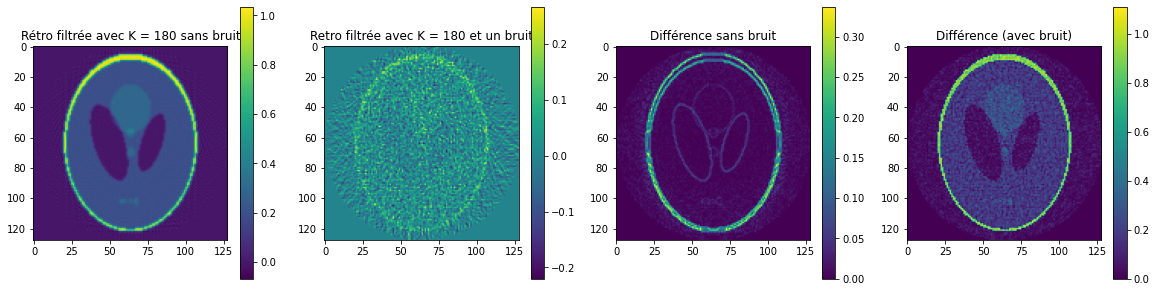

In [13]:
y = mpimg.imread("y128.png")
z2 = genereTEP(y, 180)
z2_bruit = genereTEPbruitee(y,180,0.1) 

# Résultat sans bruit 
plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.imshow(retroprojectionFiltree(z2, 180))
plt.colorbar()
plt.title('Rétro filtrée avec K = 180 sans bruit')
print("SNR sans bruit =",snr(retroprojectionFiltree(z2, 180), y))

# Résultat avec bruit
plt.subplot(1, 4, 2)
plt.imshow(retroprojectionFiltree(z2_bruit, 180))
plt.colorbar()
plt.title('Retro filtrée avec K = 180 et un bruit')
print("SNR avec bruit =",snr(retroprojectionFiltree(z2_bruit, 180), y))

# Différence dans le cas sans bruit 
plt.subplot(1, 4, 3)
plt.imshow(np.abs(y-retroprojectionFiltree(z2, 180)))
plt.colorbar()
plt.title("Différence sans bruit")

# Différence dans le cas du bruit 
plt.subplot(1, 4, 4)
plt.imshow(np.abs(y-retroprojectionFiltree(z2_bruit, 180)))
plt.colorbar()
plt.title("Différence (avec bruit)")

- Remarque : 

On remarque que lorsqu'on applique la retroprojection filtrée sur un sinogramme sans bruit, on a une meilleure reconstruction (SNR = 13.19dB) contrairement à la reconstruction avec un sinogramme bruité où l'image n'a pas été bien reconstruite avec un SNR très faible.

En revanche, la reconstruction avec un angle de 180 reste pas exacte et le SNR est quand même non élevé. 

Concernant, la différence entre l'image reconstruite et l'image originale, on constate que dans le cas de l'observation sans bruit, il y a une légère différence (image 3) au niveau des contours mais dans le cas bruité, la différence est assez remarquable (image 4) non seulement au niveau des contours (différence maximale de 1 contre 0.30 pour le cas sans bruit) mais aussi au centre, ce qui montre que l'image n'a effectivement pas été bien restaurée. 

<h4 style="color: navy bleu"> B.3. Application de la <em>retroprojectionFiltree</em> au sinogramme non bruité et bruité pour $K=45$ et visualisation

SNR sans bruit = 11.011772155761719
SNR avec bruit = -0.15176720305603825


Text(0.5, 1.0, 'Différence(avec bruit)')

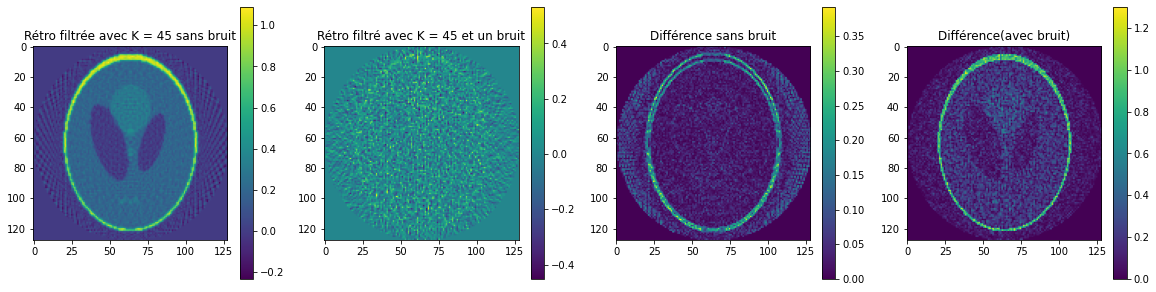

In [14]:
z3 = genereTEP(y, 45)
z3_bruit = genereTEPbruitee(y,45,0.1)

# Résultat sans bruit 
plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.imshow(retroprojectionFiltree(z3, 45))
plt.colorbar()
plt.title('Rétro filtrée avec K = 45 sans bruit')
print("SNR sans bruit =",snr(retroprojectionFiltree(z3, 45), y))

# Résultat avec bruit 

plt.subplot(1, 4, 2)
plt.imshow(retroprojectionFiltree(z3_bruit, 45))
plt.colorbar()
plt.title('Rétro filtré avec K = 45 et un bruit')
print("SNR avec bruit =",snr(retroprojectionFiltree(z3_bruit, 45), y))

# Différence dans le cas sans bruit 
plt.subplot(1, 4, 3)
plt.imshow(np.abs(y-retroprojectionFiltree(z3, 45)))
plt.colorbar()
plt.title("Différence sans bruit")

# Différence dans le cas du bruit 
plt.subplot(1, 4, 4)
plt.imshow(np.abs(y-retroprojectionFiltree(z3_bruit, 45)))
plt.colorbar()
plt.title("Différence(avec bruit)")

- Remarque :

Le résultat montre que la retroprojection filtrée du sinogramme sans bruit avec K = 45 donne une restauration meilleure(SNR = 11.01dB) que celle du sinogramme avec un bruit; mais elle reste mauvaise dans l'ensemble. On conclue que plus l'angle est petit, plus la qualité de restauration de l'image originale diminue. 

Concernant la différence entre l'image reconstruite et l'image originale,dans le cas sans bruit, il y a moins de différence au centre comparé au cas bruité où la différence est remarquable (valeur maximale est de 1.2 pour les contours). 

On en conclue donc que plus on réduit l'angle, plus la différence entre l'image originale et restaurée devient importante et plus la restauration est mauvaise. 

<h2 style="color: navy bleu"> VI. Inversion par seuillage itératif ISTA

### Critère à minimiser
On cherche une solution avec un a-priori de parcimonie en ondelettes à la synthèse i.e. $\widetilde{y}=F^{-1}\widetilde{x}$ où $\widetilde{x}$ minimise
$$\underset{x \in \mathbb R^{N_1 \times N_2}}{\text{min}} \tfrac{1}{2} \|z- \alpha \mathcal R (F^{-1}x) \|^2_2 + \lambda \|x\|_1
$$
où 
<ul>
<li>$\mathcal R$ est la transformée de Radon</li>
<li>$\alpha$ est le paramètre du bruit de Poisson sur $z$</li>
<li>$F$ représente une base en ondelettes orthonormale.</li>
<li>$\lambda$ est un paramètre de régularisation.
</ul>

### Algorithme de reconstruction ISTA
Dans le cas de la TEP, l'algorithme ISTA s'écrit

<table width=400>
<tr>
<td>$x^0 \in\mathbb R^{N_1 \times N_2}$

$x^{t+1}  =\text{Soft}_{\gamma\lambda}\left(x^t+\alpha \gamma F \mathcal R^*(z-\alpha \mathcal R F^{-1}x^t)\right)$
</td>
</tr>
</table>

où $0<\gamma<2/\beta$ est le pas de l'algorithme ($\beta$ est la constante de Lispchitz du terme différentiable), $\mathcal R^*$ est l'opérateur adjoint de $\mathcal R$, $\text{Soft}_{\lambda}$ agit ici sur chaque coordonnée de $x$ dans $\mathbb R^{N_1 \times N_2}$ indépendamment. On rappelle que l'adjoint de la transformée de Radon  $\mathcal R$ est la rétroprojection $\mathcal B$ et que:
$$
\text{Soft}_{\lambda}(x)=\begin{cases}x-\lambda & \text{si } x\geq\lambda \\
x+\lambda & \text{si } x\leq -\lambda \\
0 & \text{sinon.} \end{cases}
$$


### Calcul de la constante de Lipschitz $\beta$
<em>Calculons la constante de Lipschitz du terme différentiable i.e. de $\tfrac{1}{2} \|z- \alpha \mathcal R (F^{-1}x) \|^2_2$ et montrons que $\beta=\alpha^2 \| \mathcal R\|^2_2$ :
</em>


Soit $$G(x) = \tfrac{1}{2} \|z- \alpha \mathcal R (F^{-1}x) \|^2_2 
$$

Donc $\nabla G(x) = -\alpha R^* (F^{-1})^*  (z- \alpha \mathcal R (F^{-1}x))= \alpha R^* (F^{-1})^*  (\alpha \mathcal R (F^{-1}x)-z) $ 

$ \|\nabla G(x)-\nabla G(y)\|_2 = \left\|  \alpha R^* (F^{-1})^* ( \alpha \mathcal R (F^{-1}x)-z) -\alpha R^* (F^{-1})^*  ( \alpha \mathcal R (F^{-1}y)-z)  \right\|_2$

$\|\nabla G(x)-\nabla G(y)\|_2 = \left\|  \alpha R^* (F^{-1})^* \left [ \alpha \mathcal R (F^{-1}x)- \alpha \mathcal R (F^{-1}y)\right ]  \right\|_2$

$\|\nabla G(x)-\nabla G(y)\|_2 \leq  \alpha^2 \|R\|_2^2 \|(F^{-1})^*\|_2 \|F^{-1}(x- y)\|_2$

$\|\nabla G(x)-\nabla G(y)\|_2 \leq   \alpha^2 \|R\|_2^2 \|(F^{-1})^*\|_2 \|F^{-1}\|_2 \|x- y\|_2$

Or comme F est orthonormale, on a $F^* = F^{-1}$ donc $(F^{-1})^*= (F^*)^*= F$ 

On obtient que $\|\nabla G(x)-\nabla G(y)\|_2 \leq   \alpha^2 \|R\|_2^2  \|x- y\|_2$

On a donc $\beta=\alpha^2 \| \mathcal R\|^2_2$

<h2 style="color: navy bleu"> VII. Reconstruction par seuillage itératif


<ol>
<li>Ecrire une fonction <em>ista</em> qui prend en entrée l'image dégradée $z$, le nombre d'angles $K$, le paramètre de régularisation $\lambda$ et le nombre d'itérations $T$ et qui donne en retour l'image restaurée par ISTA en effectuant $T$ itérations. A chaque itération, les étapes clés sont :
<ol>
<li> Application de la transformée en ondelettes $F$ (<em>wavedec2</em>). On prendra des ondelettes de Daubechies (longueur 4), 5 niveaux de résolution et on s'assurera de faire des extensions périodiques;</li>
<li> Application de la transformée de Radon $\mathcal R$ : utilisation de la fonction <em>genereTEP</em>;</li>
<li> Application l'adjoint $\mathcal R^*$ : c'est la rétroprojection, on utilise la fonction <em>retroprojection</em>;</li>
<li> Application de la transformée en ondelettes inverse $F^{-1}$ (<em>waverec2</em>).</li>
<li> Le seuillage doux (<em>threshold</em>).
</ol>
</li>
<br>
<li> Appliquer l'algorithme ISTA pour reconstruire l'image dégradée $z$ pour laquelle on choisira $\alpha=0.1$ avec différentes valeurs de $\lambda$ (on pourra déjà essayer avec $\lambda=0.5$ par exemple).
Noter que l'on a  $\|\mathcal R\|^2_2=  200$.
Donner également un ou plusieurs critères numériques sur la qualité de reconstruction.
<br>
Note: il faut veiller à faire suffisamment d'itérations ($T$ grand) pour arriver à convergence. Pour le vérifier, on peut ajouter une figure dans <em>ista</em> traçant $||x_{t+1} - x_{t}||$ en fonction de $t$ où $t \in \{1,...,T\}$. On peut également ajouter une autre figure  dans <em>ista</em> traçant l'évolution du critère au cours des itérations, c'est à dire $\tfrac{1}{2} \|z- \alpha \mathcal R (F^{-1}x_t) \|^2_2 + \lambda \|x_t\|_1$.</li>
<br>
<li> Comparer qualitativement et quantitativement les résultats obtenus avec cet algorithme et avec les résultats obtenus avec la retroprojection filtrée.
</ol>

<h3 style="color: navy bleu"> A. Création de la fonction Ista </h3> 

Elle prend en entrée l'image dégradée $z$, le nombre d'angles $K$, le paramètre de régularisation $\lambda$ et le nombre d'itérations $T$ et qui donne en retour l'image restaurée par ISTA en effectuant $T$ itérations.

In [15]:
def ista(z,K,l,T):
    
    """
    z : observations
    K : le nombre d'angles
    l : paramètre de régularisation 
    T : nombre d'itération
    
    """
    #initialisation
    y = retroprojection(z,K)
    resNorm = np.zeros((T,1))
    M = np.zeros((T,1))
    coeffs = pywt.wavedec2(y, 'db4',mode='periodization',level=5) 
    x, coeff_slices = pywt.coeffs_to_array(coeffs)
    #Boucle
    for i in np.arange(0,T,1):
        # Transformee ondelette inverse
        y = pywt.waverec2(coeffs, 'db4',mode='periodization')
        # transformée de Radon  R
        y = genereTEP(y,K)
        y = z - 0.1*y
        M[i]= 0.5*np.sum((y)**2) + l*np.sum(np.abs(x))
        # retroprojection 
        y = retroprojection(y,K)
        # Mise à jour des coefficients
        coeffs = pywt.wavedec2(y, 'db4',mode='periodization',level=5)
        xtmp, coeff_slices = pywt.coeffs_to_array(coeffs)
        xplus = pywt.threshold(x + 0.1*1*xtmp,l,'soft')
        coeffs = pywt.array_to_coeffs(xplus, coeff_slices,output_format='wavedec2') 
        # Calcul de la norme residuelle
        resNorm[i] = np.sum((x-xplus)**2)
        x=xplus
    y = pywt.waverec2(coeffs, 'db4',mode='periodization')
    #plt.figure(20)
    plt.semilogy(resNorm,label = f'lambda = {str(l)}')
    #plt.title('||x^{t+1} - x^t||')
    #plt.show() 
    return y

<h3 style="color: navy bleu"> B. Application de l'algorithme ISTA pour reconstruire l'image dégradée 

<h4 style="color: navy bleu"> B.1. Pour z bruitée 

C:\Users\saida\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\saida\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\saida\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\saida\a

[]

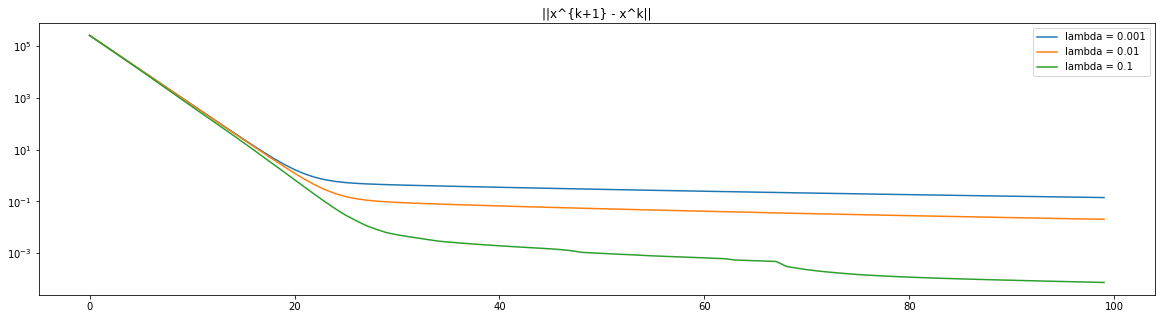

In [16]:
# Image bruitée
z_bruite = genereTEPbruitee(y,180,0.1)

l = [0.001, 0.01, 0.1]

y_prime_ista = []

plt.figure(figsize=(20,5))
for i in range(len(l)):
    y_prime_ista.append(np.real(ista(z_bruite,180,l[i],100)))
    

plt.title('||x^{k+1} - x^k||') 
plt.legend()
plt.plot()


On constate que plus $\lambda$ est grand, plus l'algorithme converge vite. 

<h4 style="color: navy bleu"> B.2. Pour z non bruitée 

C:\Users\saida\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\saida\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\saida\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\saida\a

[]

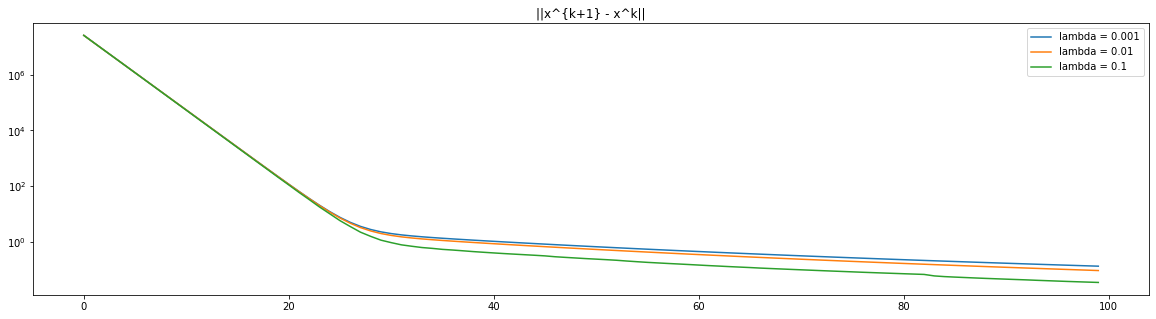

In [17]:
# Image non bruitée 
z_non_bruite = genereTEP(y,180)

l = [0.001, 0.01, 0.1]
y_prime_ista2 = []

plt.figure(figsize=(20,5))
for i in range(len(l)):
    y_prime_ista2.append(np.real(ista(z_non_bruite,180,l[i],100)))
    

plt.title('||x^{k+1} - x^k||') 
plt.legend()
plt.plot()

On constate que plus $\lambda$ est grand, plus l'algorithme converge vite également.

<h3 style="color: navy bleu"> C. Comparaison  qualitative et quantitative des résultats obtenus 

<h4 style="color: navy bleu"> C.1. Pour z bruitée 

SNR(y_prime_ista,y) avec lambda de 0.001 : 0.6601449375370121
PSNR(y_prime_ista,y) avec lambda de 0.001: 53.54139036281553

SNR(y_prime_ista,y) avec lambda de 0.01 : 1.6498646895207425
PSNR(y_prime_ista,y) avec lambda de 0.01: 59.16364801528751

SNR(y_prime_ista,y) avec lambda de 0.1 : 0.22517739516878105
PSNR(y_prime_ista,y) avec lambda de 0.1: 63.69117006223157



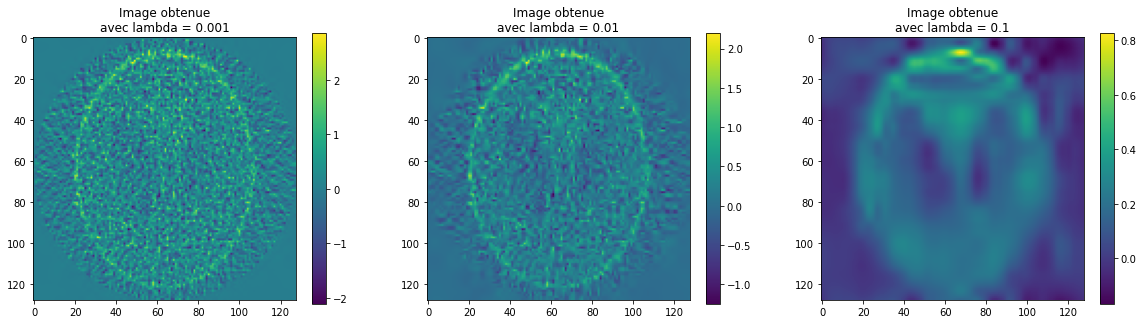

In [18]:
l = [0.001, 0.01, 0.1]
# taille de la figure 
plt.figure(figsize=(20,5))

# Faire une boucle pour afficher chaque image associée à chaque lambda 
for i in range(len(l)): 

    #y_ista= np.real(ista(z,180,l[i],100))
    # Pour afficher les images sur une seule ligne 
    plt.subplot(1, len(l), i+1)
    plt.imshow(np.array(y_prime_ista[i]))
    plt.colorbar()
    plt.title(f'Image obtenue\navec lambda = {l[i]}')

    print(f'SNR(y_prime_ista,y) avec lambda de {l[i]} : {snr(y,y_prime_ista[i])}')
    print(f'PSNR(y_prime_ista,y) avec lambda de {l[i]}: {psnr(y,y_prime_ista[i])}\n')

<h4 style="color: navy bleu"> C.1. Pour z non bruitée 

SNR(y_prime_ista,y) avec lambda de 0.001 : 0.9516756236553192
PSNR(y_prime_ista,y) avec lambda de 0.001: 41.81505031712949

SNR(y_prime_ista,y) avec lambda de 0.01 : 0.957653820514679
PSNR(y_prime_ista,y) avec lambda de 0.01: 41.975075311373196

SNR(y_prime_ista,y) avec lambda de 0.1 : 0.9735552221536636
PSNR(y_prime_ista,y) avec lambda de 0.1: 42.737991033424805



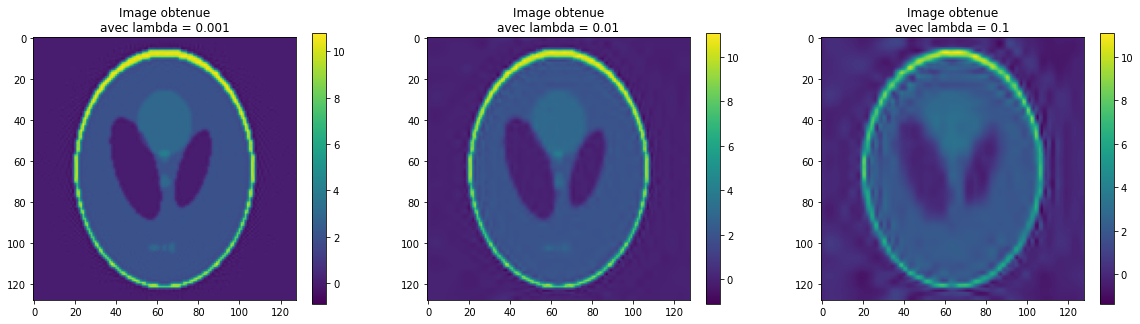

In [19]:
l = [0.001, 0.01, 0.1]
# taille de la figure 
plt.figure(figsize=(20,5))

# Faire une boucle pour afficher chaque image associée à chaque lambda 
for i in range(len(l)): 

    #y_ista= np.real(ista(z,180,l[i],100))
    # Pour afficher les images sur une seule ligne 
    plt.subplot(1, len(l), i+1)
    plt.imshow(np.array(y_prime_ista2[i]))
    plt.colorbar()
    plt.title(f'Image obtenue\navec lambda = {l[i]}')

    print(f'SNR(y_prime_ista,y) avec lambda de {l[i]} : {snr(y,y_prime_ista2[i])}')
    print(f'PSNR(y_prime_ista,y) avec lambda de {l[i]}: {psnr(y,y_prime_ista2[i])}\n')

- Conclusion 
    
On constate que lorsqu'on essaie de restaurer une image bruitée avec $\lambda = 0.001$ de l'algorithme ISTA, on a une reconstruction faible avec un SNR de 0.66dB mais à force de prendre un $\lambda$ plus grand, l'algorithme n'arrive pas à bien reconstruire l'image même si pour cette valeur, l'algorithme converge mieux. 

En revanche, avec une image non bruitée, on a un SNR un peu plus grand (0.97 pour $\lambda=0.1$ pour lequel l'algorithme Ista converge plus rapidement) mais l'image reconstruite avec $\lambda = 0.01$ est moins floue.    

Si on compare les résultats avec ceux de la rétroprojection, on rappelle qu'on a obtenu :  


$$\begin{array}{|c|c|c|c|}
\hline
& \text{Valeurs des paramètres} & \text{Sans bruit} & \text{Avec bruit} \\
\hline
\text{ISTA} & \begin{array}{ll}\lambda=0.001\\ \lambda=0.01\\ \lambda=0.1 \end{array} & \begin{array}{r}0.95\\0.96\\0.97\end{array} & \begin{array}{r}0.66\\1.65\\0.23 \end{array}\\
\hline
\text{Rétroprojection} & \begin{array}{l}k = 180 \\ k=45 \end{array} & \begin{array}{r}13.19\\11.01\end{array} & \begin{array}{r}0.58\\-0.15\end{array} \\
\hline
\end{array}$$

On remarque qu'on a un SNR plus grand avec la rétroprojection filtrée dans le cas non bruité notamment avec un angle de 180 où le SNR est de 13.19 dB. Pour le cas bruité, Ista donne un SNR de 0.58 dB contre 0.66dB pour l'algo ISTA ayant un $\lambda $ faible. En général, la rétroprojection filtrée est meilleur que ISTA dans le cas d'observations non bruitées et dans le cas bruité, ISTA est légérement meilleur. 